## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.regularizers import l2, l1_l2
from keras.layers import Input, Dense, Dropout, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128, 32], regulizer=l2, regulizer_ratio=1e-7, 
              dropout=False, drop_ratio=0.2, batchnormalization=False):
    """
    Build your own model
    """
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), 
                      kernel_regularizer=regulizer(regulizer_ratio))(input_layer)
            if dropout == True:
                x = Dropout(drop_ratio)(x)
            if batchnormalization == True:
                x = BatchNormalization()(x)    
        else:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), 
                      kernel_regularizer=regulizer(regulizer_ratio))(x)
            if dropout == True:
                x = Dropout(drop_ratio)(x)
            if batchnormalization == True:
                x = BatchNormalization()(x)   
    
    out = Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
epochs = 50
batch_size = 256
regulizer = [l2, l1_l2]
regulizer_ratio = [1e-7, 1e-10]
dropout = [False, True, False]
batchnormalization = [False, False, True]

In [7]:
results = {}
"""
Write your training loop and record results
"""
for reg in regulizer:
    for reg_ra in regulizer_ratio:
        for d_b in zip(dropout, batchnormalization):
            keras.backend.clear_session() # 把舊的 Graph 清掉
            print(f'regulizer = {reg}, regulizer_ratio = {reg_ra}, dropout = {d_b[0]}, batchnormalization = {d_b[1]}')
            model = build_mlp(input_shape=x_train.shape[1:], regulizer=reg, regulizer_ratio=reg_ra, 
                              dropout=d_b[0], batchnormalization=d_b[1])
            model.summary()
            optimizer = keras.optimizers.SGD(lr=0.01, nesterov=True, momentum=0.9)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

            name_tag = f'regulizer = {reg}, regulizer_ratio = {reg_ra}, dropout = {d_b[0]}, batchnormalization = {d_b[1]}'
            results[name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 
                                 'train-acc': train_acc, 'valid-acc': valid_acc}

regulizer = <function l2 at 0x000002D961C1D4C8>, regulizer_ratio = 1e-07, dropout = False, batchnormalization = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                4128      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 1,643,498
Trainable params: 1,643,498
Non-trainable params: 0
_______________________________________________________________

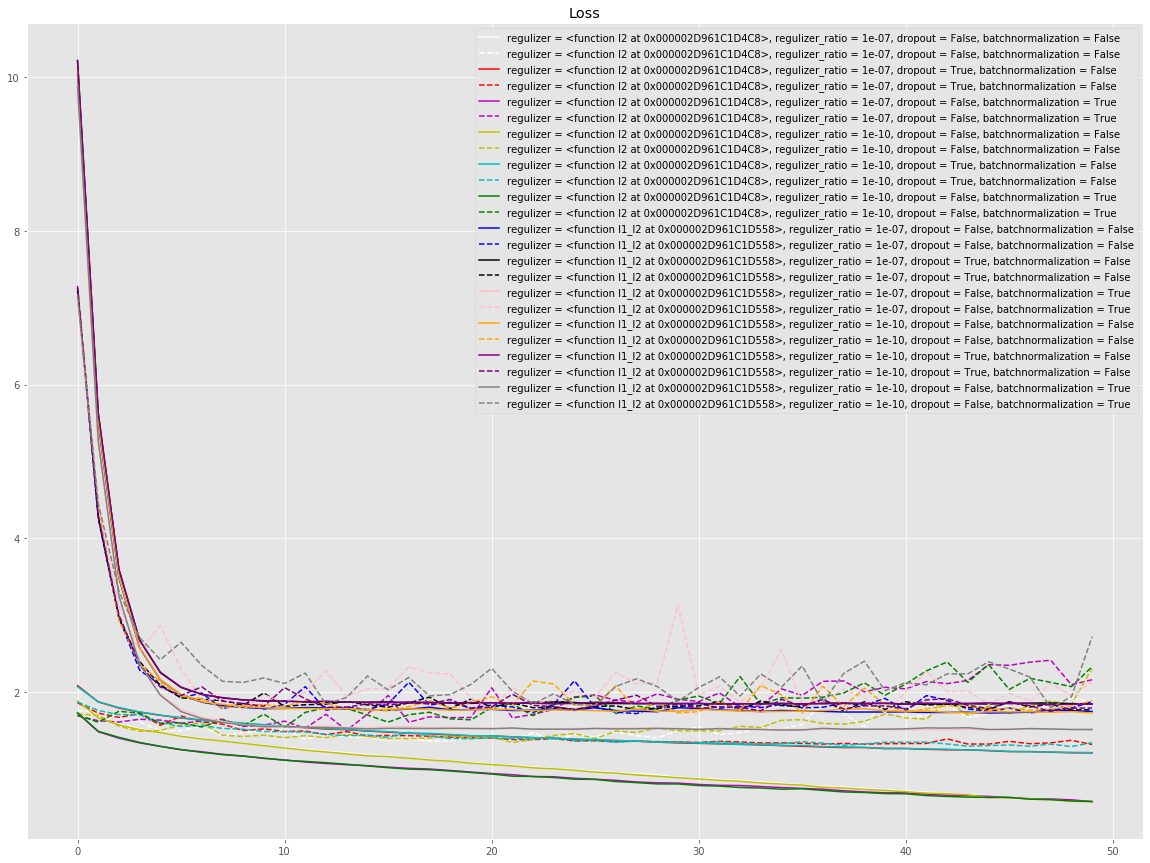

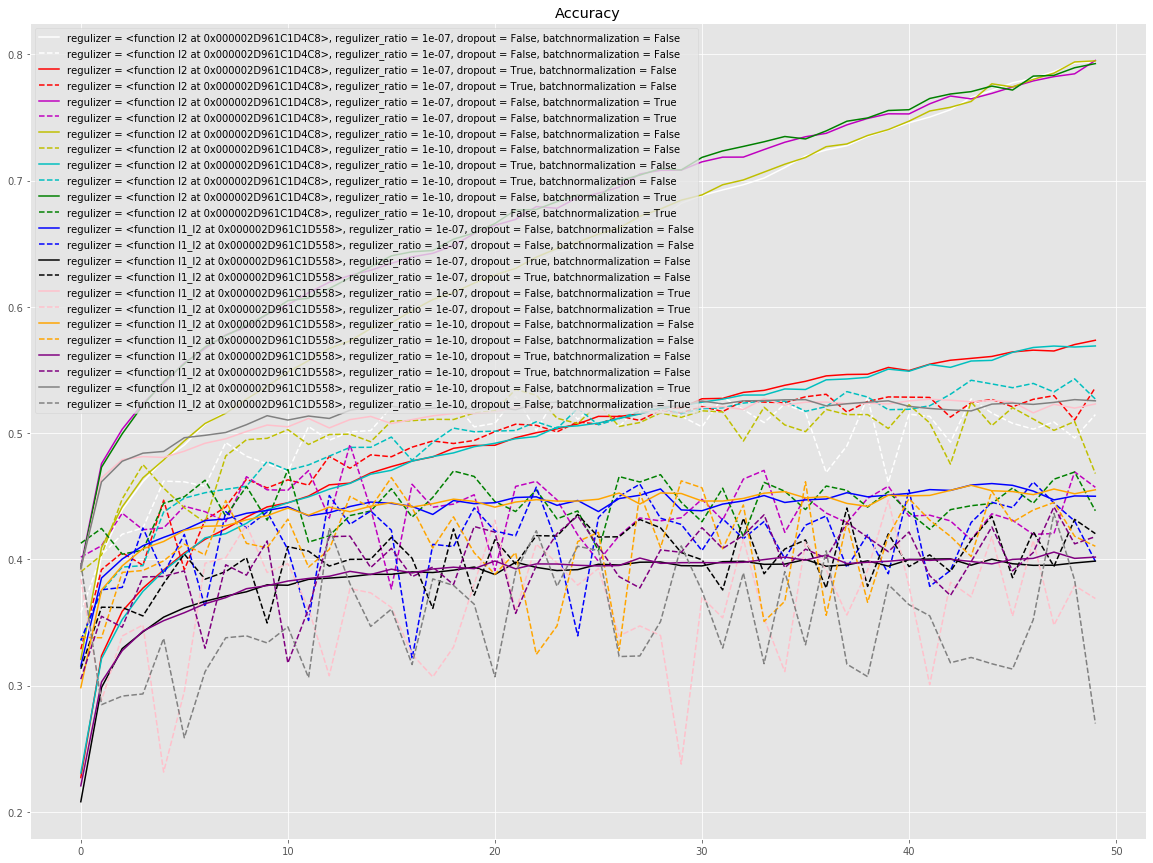

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
Plot results
"""
plt.style.use('ggplot')
color_bar = ['w', 'r', 'm', 'y', 'c', 'g', 'b', 'k', 'pink', 'orange', 'purple', 'gray']

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()